**Подключение библиотек и чтение данные**

In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('data/data.csv')

**Формирование тренировочного и тестового датасета. В df_test будут содержаться значения, которые равны None в столбце "Дата окончания поиска" в исходном датасете. Будет считатся, что такие поиски не закончены и нужно предсказать, когда они закончатся**

In [2]:
df_test = df[df['Дата окончания поиска'].isnull()]
df_train = df.dropna(subset=['Дата окончания поиска'])

**Удаление строк с временем, так как все строки с потраченным временем и датами начала и конце зависят от общего затраченного на поиски времени. Также удаляется стобец "Статус поиска", так как мы определили, какие поиски завершены, а какие продолжаются**

*Замечание - есть признаки с значением "в процессе" в столбце "Статус поиска" и с определенной датой окончания. Считаю, что это шум и такое событие завершено, просто забыли установить в "Статусе поиска" метку "завершен"*

In [3]:
pd.options.mode.chained_assignment = None

df_train['target'] = (pd.to_datetime(df_train['Дата окончания поиска']) - pd.to_datetime(df_train['Дата начала поиска'])).dt.total_seconds()
df_train = df_train.drop(['Общее время поиска', 'Общее время активного поиска', 'Общее время простоев', 'Дата окончания поиска', 
                          'Дата начала поиска', 'Статус поиска'], axis=1)
df_test = df_test.drop(['Общее время поиска', 'Общее время активного поиска', 'Общее время простоев', 'Дата окончания поиска', 
                        'Дата начала поиска', 'Статус поиска'], axis=1)

**Также признаки с количеством простоев в различных ситуациях можно объединить в один признак "Общее количество простоев". При исследовании было выявлено, что признак "Количество простоев в поиске" больше или равен всем остальным признакам с количеством простоев, поэтому я не складываю значения всех признаков с простоем, а оставляю один признак "Количество простоев в поиске"**

In [4]:
df_train['Общее количество простоев'] = df_train['Количество простоев в поиске']
df_train = df_train.drop(['Количество простоев по метеоусловиям', 'Количество простоев', 'Количество простоев без виновника', 'Количество простоев по вине королевства',
                          'Количество простоев в наклонном поиске', 'Количество простоев по зельям', 'Количество простоев в контроле поиска', 
                          'Количество простоев в конце расщелины', 'Количество простоев по долбилам', 'Количество простоев по вине исследователей', 
                          'Количество простоев по креплениям', 'Количество простоев (прочие)', 'Количество простоев в поиске'], axis=1)

df_test['Общее количество простоев'] = df_test['Количество простоев в поиске']
df_test = df_test.drop(['Количество простоев по метеоусловиям', 'Количество простоев', 'Количество простоев без виновника', 'Количество простоев по вине королевства',
                          'Количество простоев в наклонном поиске', 'Количество простоев по зельям', 'Количество простоев в контроле поиска', 
                          'Количество простоев в конце расщелины', 'Количество простоев по долбилам', 'Количество простоев по вине исследователей', 
                          'Количество простоев по креплениям', 'Количество простоев (прочие)', 'Количество простоев в поиске'], axis=1)

df_train['Общее количество простоев'] = df_train['Общее количество простоев'].fillna(df_train['Общее количество простоев'].mode().iloc[0])
df_test['Общее количество простоев'] = df_test['Общее количество простоев'].fillna(df_test['Общее количество простоев'].mode().iloc[0])

**Удаление выбросов. Посмотрим, насколько сильно разрежены признаки**

In [5]:
df_train.isnull().sum()

Наименование королевства                   0
Наименование земли                         0
Наименование хребта                        0
Наименование расщелины                     0
Цель                                       0
Тип расщелины                              2
Категория расщелины                        0
Назначение расщелины                    2616
Участки                                    0
Тип отвилка                                0
Технологическая особенность                0
Помощник по контролю поиска                0
Помощник по поиску                         0
Помощник по наклонным расщелинам           0
Помощник по зельям                         0
Помощник по долбилам                       0
Помощник по исследованиям                  0
Помощник по укреплению                     0
Помощник по огненным заклятиям             0
Помощник по подвескам                      0
Помощник по вырезке окна                   0
Тип инструмента                            0
Количество

*Посмотрев на некоторые признаки можно заметить, что в некоторых столбцах много нулей и неизвестных значений, например в "Глубина первого отвилка",'Путь поиска в первом отвилке', 'Количество аварий' итд*

<Axes: >

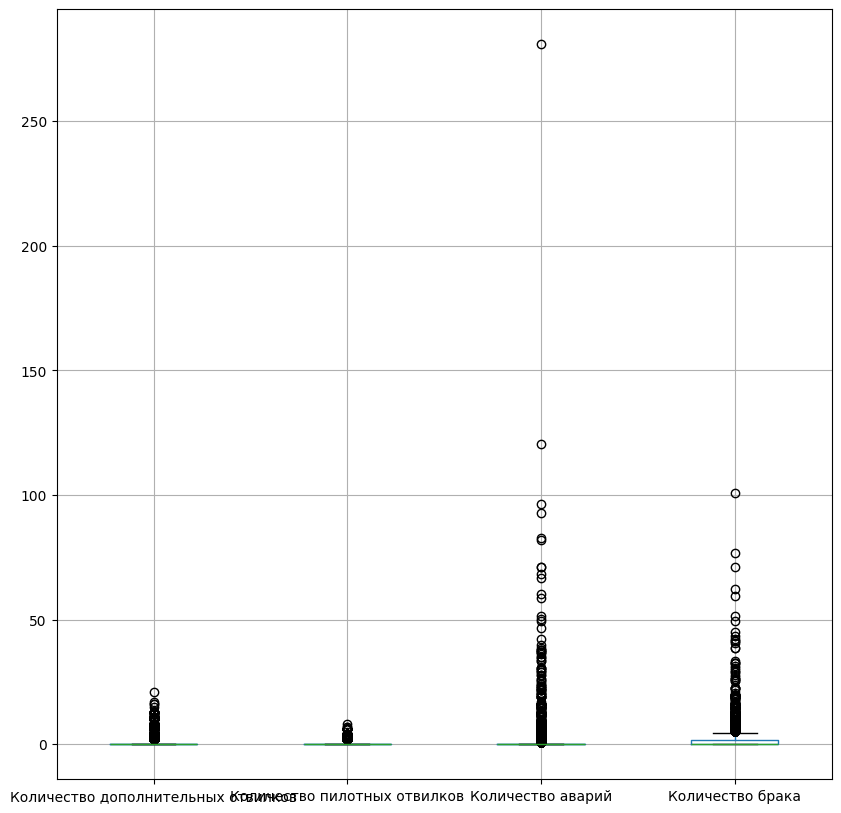

In [6]:
df_train.boxplot(['Количество дополнительных отвилков', 'Количество пилотных отвилков', 'Количество аварий', 'Количество брака'], figsize=(10, 10))

<Axes: >

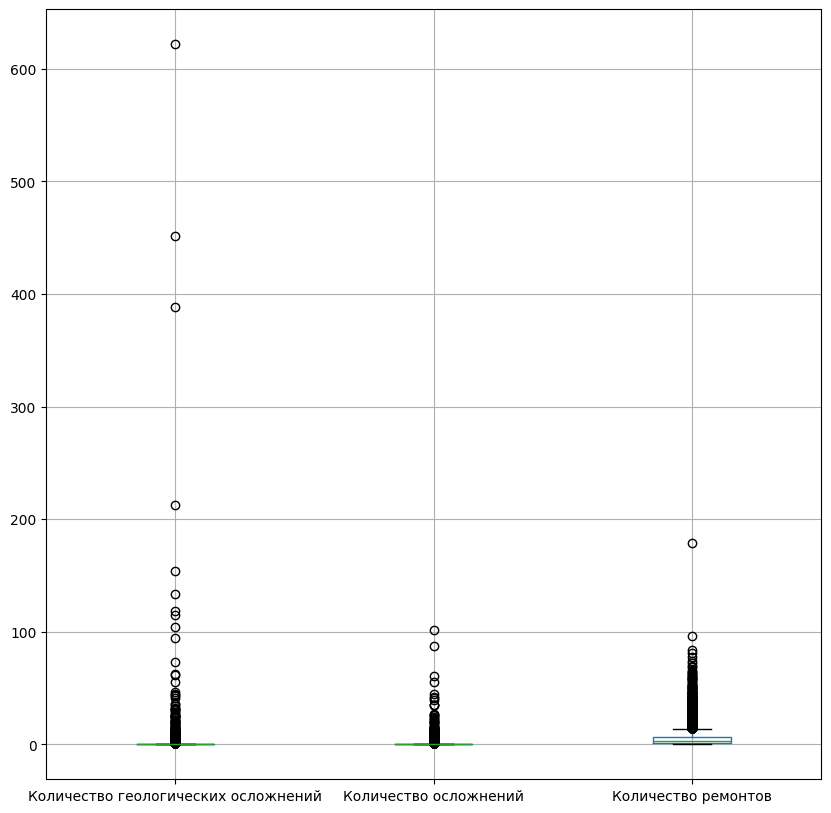

In [71]:
df_train.boxplot(['Количество геологических осложнений', 'Количество осложнений', 'Количество ремонтов'], figsize=(10, 10))

<Axes: >

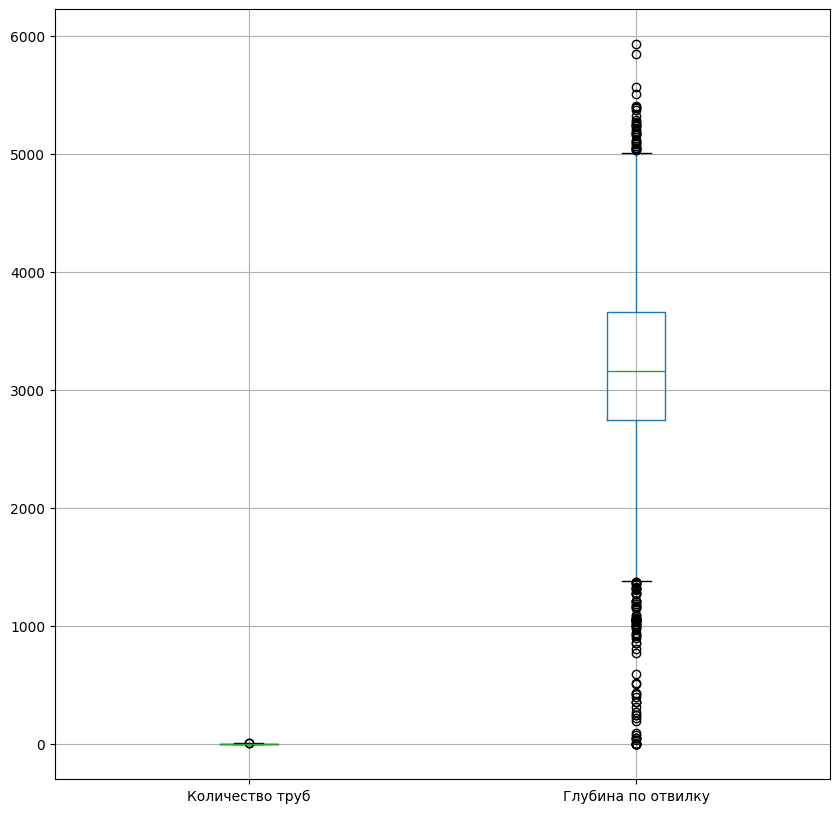

In [72]:
df_train.boxplot(['Количество труб','Глубина по отвилку'], figsize=(10, 10))

<Axes: >

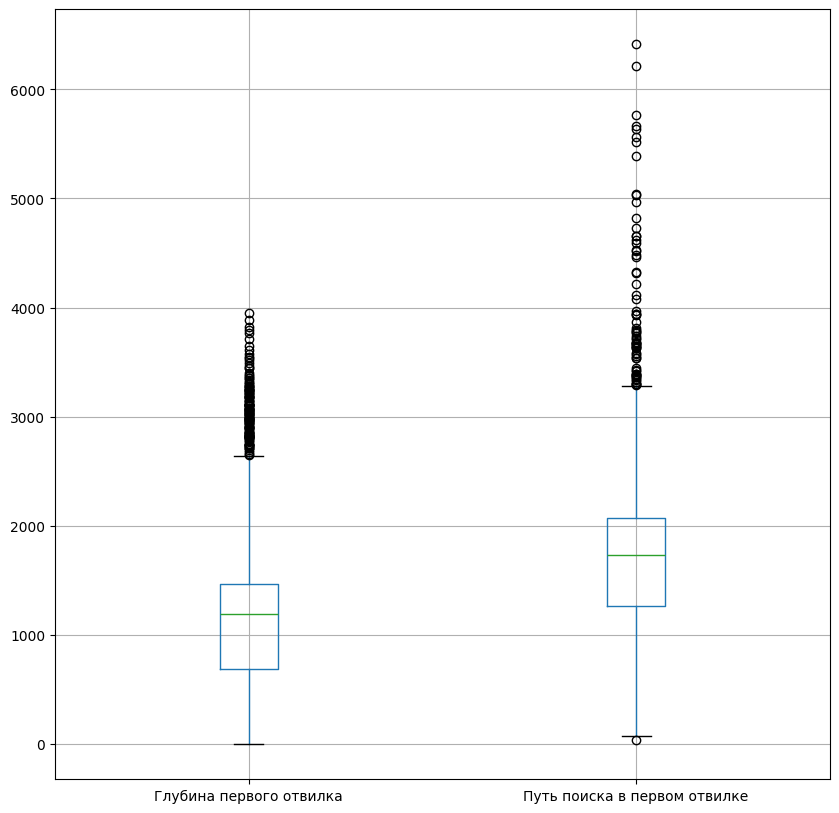

In [73]:
df_train.boxplot(['Глубина первого отвилка','Путь поиска в первом отвилке'], figsize=(10, 10))

*Итого, все рассматриваемые признаки, кроме "Количества труб" и "Глубина по отвилку" имеют большое количество неопределенных значений и нулей (у "Количества труб" мало выбросов, а в "Глубина по отвилку" ненулевые значения)* 

*Наверно можно было бы исходные значения перекодировать и учитывать при обучении, но я их удалю, так как думаю, что в датасете есть фичи, которые более полно объясняют данные* (Можно проверить с помощью VarianceThreshold на сколько полно эти фичи объясняют выборку, но может потом)

In [6]:
df_train = df_train.drop(['Количество дополнительных отвилков', 'Количество пилотных отвилков', 'Количество аварий', 'Количество брака', 
                          'Количество геологических осложнений', 'Количество осложнений', 'Количество ремонтов'], axis=1)
df_test = df_test.drop(['Количество дополнительных отвилков', 'Количество пилотных отвилков', 'Количество аварий', 'Количество брака', 
                          'Количество геологических осложнений', 'Количество осложнений', 'Количество ремонтов'], axis=1)

*Глубину первого отвилка и путь поиска в первом отвилке удалим, так как много неизвестных значений*

In [7]:
print('Процент неизвестных данные по "Глубине первого отклика" = ', df_train['Глубина первого отвилка'].isnull().sum()/df_train.shape[0])
print('Процент неизвестных данные по "Путь поиска в первом отвилке" = ', df_train['Путь поиска в первом отвилке'].isnull().sum()/df_train.shape[0])

Процент неизвестных данные по "Глубине первого отклика" =  0.8894685113782415
Процент неизвестных данные по "Путь поиска в первом отвилке" =  0.8856127617751569


In [8]:
df_train = df_train.drop(['Глубина первого отвилка', 'Путь поиска в первом отвилке'], axis=1)
df_test = df_test.drop(['Глубина первого отвилка', 'Путь поиска в первом отвилке'], axis=1)

*"Глубина по отвилку" и "Количество труб" очищаем от выбросов*

In [9]:
Q1 =  df_train['Глубина по отвилку'].quantile(0.25)
Q3 = df_train['Глубина по отвилку'].quantile(0.75)
IQR = Q3 - Q1
df_train = df_train[~((df_train['Глубина по отвилку'] < Q1-1.5*IQR ) | (df_train['Глубина по отвилку'] > Q3+1.5*IQR))]

Q1 =  df_train['Количество труб'].quantile(0.25)
Q3 = df_train['Количество труб'].quantile(0.75)
IQR = Q3 - Q1
df_train = df_train[~((df_train['Количество труб'] < Q1-1.5*IQR ) | (df_train['Количество труб'] > Q3+1.5*IQR))]

Q1 =  df_test['Глубина по отвилку'].quantile(0.25)
Q3 = df_test['Глубина по отвилку'].quantile(0.75)
IQR = Q3 - Q1
df_test = df_test[~((df_test['Глубина по отвилку'] < Q1-1.5*IQR ) | (df_test['Глубина по отвилку'] > Q3+1.5*IQR))]

Q1 =  df_test['Количество труб'].quantile(0.25)
Q3 = df_test['Количество труб'].quantile(0.75)
IQR = Q3 - Q1
df_test = df_test[~((df_test['Количество труб'] < Q1-1.5*IQR ) | (df_test['Количество труб'] > Q3+1.5*IQR))]

*Заменяем неизвестные значения с типом float64 на моду* 

In [10]:
df_train['Общий путь поиска'] = df_train['Общий путь поиска'].fillna(df_train['Общий путь поиска'].mode().iloc[0])
df_train['Количество труб'] = df_train['Количество труб'].fillna(df_train['Количество труб'].mode().iloc[0])
df_train['Глубина по отвилку'] = df_train['Глубина по отвилку'].fillna(df_train['Глубина по отвилку'].mode().iloc[0])

df_test['Общий путь поиска'] = df_test['Общий путь поиска'].fillna(df_test['Общий путь поиска'].mode().iloc[0])
df_test['Количество труб'] = df_test['Количество труб'].fillna(df_test['Количество труб'].mode().iloc[0])
df_test['Глубина по отвилку'] = df_test['Глубина по отвилку'].fillna(df_test['Глубина по отвилку'].mode().iloc[0])

**Кодирование категориальных фич с использованием Label Encoder** 

*Заметил, что в некоторых фичах много пропусков, найду все такие фичи, где пропусков больше 80% и удалю их*

In [11]:
list_col = list(df_train.columns)
list_col_del = []
for i in range(len(list_col)):
    t = df_train[df_train[list_col[i]] == ' '][list_col[i]].value_counts()
    if len(t) > 0:
        if (t.iloc[0] / df_train.shape[0]) >= 0.8:
            list_col_del.append(list_col[i])
        
df_train = df_train.drop(list_col_del, axis=1)
df_test = df_test.drop(list_col_del, axis=1)

*Теперь закодируем все категориальные фичи*

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
list_types = list(df_train.select_dtypes(['object']))
for i in range(len(list_types)):
    df_train.loc[:, list_types[i]] = le.fit_transform(df_train.loc[:, list_types[i]])
    df_test.loc[:, list_types[i]] = le.fit_transform(df_test.loc[:, list_types[i]])

*Определим, есть зависимость между фичами - проверка, есть ли у нас мультиколлениарность*

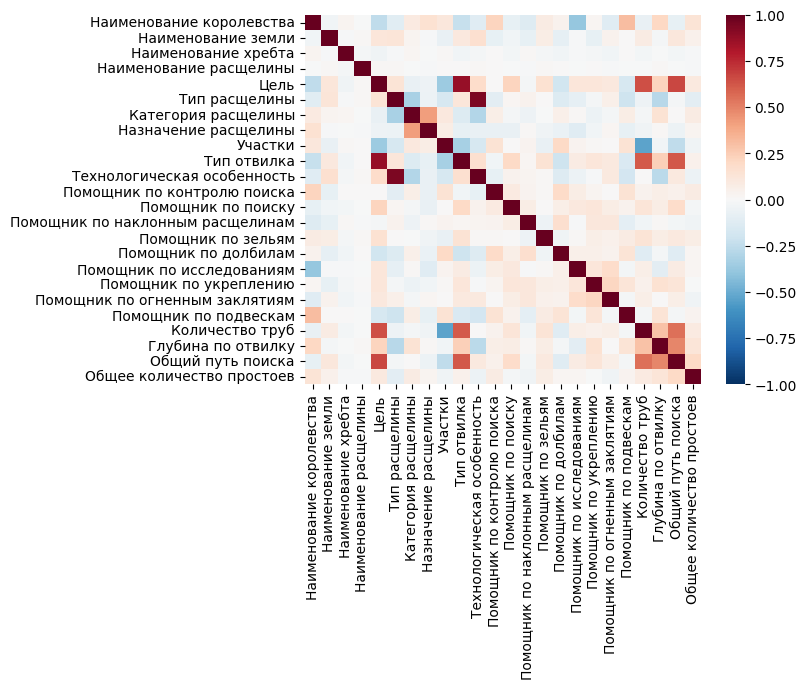

In [81]:
sns.heatmap(
    df_train.drop(['target'], axis=1).corr(),        
    cmap='RdBu_r',
    annot=False, 
    vmin=-1, vmax=1); 

*Видим, что некоторые фичи коррелируют между собой, создавая проблему мультколлениарности, проверим их с помощью метода variance_inflation_factor, если значение метрики превысит 5, то удаляем столбец*

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIFs = pd.DataFrame()
df_VIF = df_train.select_dtypes(['float64', 'int64']).drop(['target'], axis=1)
VIFs['Variable'] = df_VIF.columns
VIFs['VIF'] = [variance_inflation_factor(df_VIF.values, i) for i in range(df_VIF.shape[1])]
VIFs = VIFs[VIFs['VIF'] > 5].reset_index(drop=True)

list_df = list(VIFs['Variable'])
df_train = df_train.drop(list_df, axis=1)
df_test = df_test.drop(list_df, axis=1)

**Теперь обучим Random Forest Regressor, возьмем лучшие фичи и еще раз обучим модель**

In [14]:
X_test = df_test.copy()
X_train = df_train.drop(['target'], axis=1)
y_train = pd.DataFrame({'target' : df_train['target']})

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

<Axes: xlabel='Importance', ylabel='Features'>

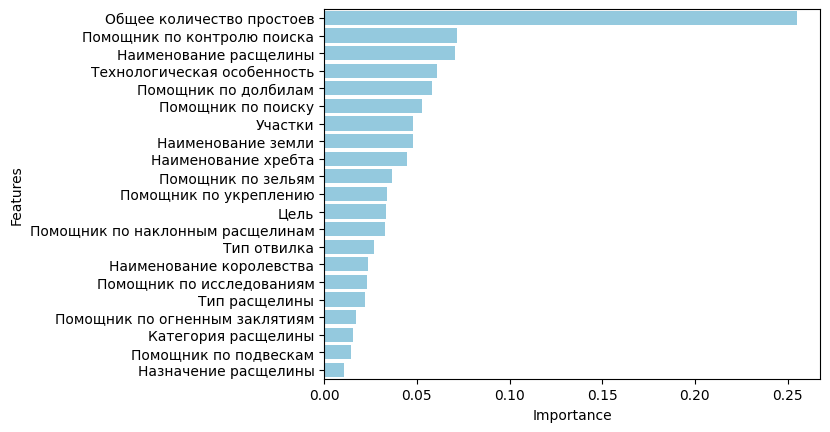

In [16]:
feats = {}
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')

*Заметим, что очень важной фичей является "общее количество простоев", остальные фичи менее важны для модели*

**Оценим модель рандомного дерева пока со всеми фичами**

In [86]:
from sklearn.model_selection import cross_val_score

mse = cross_val_score(model,
                      X_train,
                      y_train,
                      scoring='neg_mean_squared_error',
                      cv=X_train.shape[1])

mse.mean()

c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473:

np.float64(-3200400078410.712)

*Получаем оценку **-3200400078410.712** используя метрику среднеквадратичной ошибки*

**Попробуем отобрать 10 лучших фич из полученных ранее результатов**

In [87]:
X_train = X_train[list(importances['Features'].head(10))]
X_test = X_test[list(importances['Features'].head(10))]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_1 = RandomForestRegressor()
model_1.fit(X_train, y_train)

c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

<Axes: xlabel='Importance', ylabel='Features'>

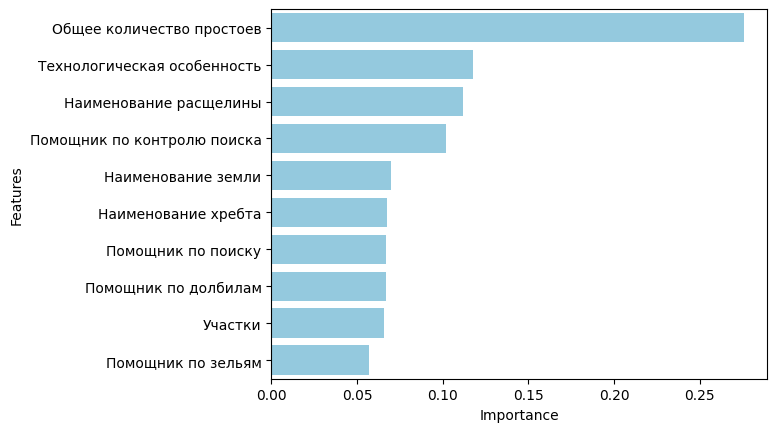

In [ ]:
feats = {}
for feature, importance in zip(X_train.columns, model_1.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')

In [ ]:
from sklearn.model_selection import cross_val_score

mse = cross_val_score(model_1,
                      X_train,
                      y_train,
                      scoring='neg_mean_squared_error',
                      cv=X_train.shape[1])

mse.mean()

c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473:

np.float64(-3421375149293.209)

*Увы, ошибка получилась больше, чем в прошлом эксперименте*

**Попробуем обучить линейную модель с использованием Lasso-регуляризции**

In [96]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alpha_values = {'alpha': [i for i in range(1, 50, 5)]}

lasso = GridSearchCV(Lasso(),
                     alpha_values,
                     scoring='neg_mean_squared_error',
                     cv=X_train.shape[1])

print('Лучшее значение alpha:', lasso.fit(X_train, y_train).best_params_)

print('Метрика качества:', lasso.fit(X_train, y_train).best_score_)

Лучшее значение alpha: {'alpha': 46}
Метрика качества: -3714716880822.0234


*Увы, этот эксперимент тоже неудачен. Ridge-регуляризацию не использую так как она зануляет неважные признаки, а я их уже убрал*

**Попробуем отобрать признаки с помощью функции chi2 (хи-квадрат тест). Отберем 10 лучших признаков**

In [36]:
X_test = df_test.copy()
X_train = df_train.drop(['target'], axis=1)
y_train = pd.DataFrame({'target' : df_train['target']})

In [37]:
from sklearn.feature_selection import SelectKBest, chi2
X_train_new = SelectKBest(chi2, k=10).fit_transform(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_2 = RandomForestRegressor()
model_2.fit(X_train_new, y_train)

c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [ ]:
from sklearn.model_selection import cross_val_score

mse = cross_val_score(model_2,
                      X_train_new,
                      y_train,
                      scoring='neg_mean_squared_error',
                      cv=X_train.shape[1])

mse.mean()

c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\mArt\dataScience\GPN_Cup\Разветка и добыча нефти\.venv\lib\site-packages\sklearn\base.py:1473:

np.float64(-3384055605011.9375)

*В итоге, лучший эксперимент самый первый с использованием всех признаков в RF*

**Хорошо бы попробовать подобрать параметры для этой модели, но я не успел(**

In [18]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [300,500,700]
# max_features = ['sqrt']
# max_depth = [2,3,7,11,15]
# min_samples_split = [2,3,4,22,23,24]
# min_samples_leaf = [2,3,4,5,6,7]
# bootstrap = [False]
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# gs = GridSearchCV(model, param_grid, cv = 2, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# m = gs.best_estimator_
# gs.best_params_

**Итого, предсказываю время поиска артефактов**

In [21]:
y_pred = model.predict(X_test)
y_pred

array([ 3985362.  ,  4034374.8 ,  4351556.4 ,  4288517.4 ,  2868278.4 ,
        6904194.  ,  3293109.  ,  4335771.  ,  6024392.4 ,  3391659.  ,
        4034394.  ,  4847787.  ,  2798896.8 ,  6279874.2 ,  2542052.4 ,
        2638278.  ,  3008939.4 ,  5336532.  ,  3135312.  ,  5401813.8 ,
        5140025.4 ,  2507799.  ,  4393215.  ,  2938326.  ,  6053784.  ,
        5346863.4 ,  3044808.  ,  2639420.4 ,  3132738.  ,  4397515.8 ,
        3352143.  ,  4451388.6 ,  3372867.  ,  3367620.  ,  3252245.4 ,
        5498604.6 ,  2999599.8 ,  4963899.  ,  2616746.4 ,  2593392.  ,
        4397362.8 ,  5005974.  ,  4869162.  ,  4138801.8 ,  3737835.  ,
        2594510.4 ,  2737645.8 ,  3536322.  ,  2916798.  ,  3174381.  ,
        2377239.  ,  5205026.4 ,  2912784.  ,  3172104.  ,  3977136.  ,
        6428061.  ,  2676773.4 ,  5022538.8 ,  3027519.  ,  4072266.  ,
        5090006.4 ,  2494194.6 ,  4222392.  ,  4034923.8 ,  6021396.  ,
        2957292.  ,  3662118.  ,  3086982.  ,  3907683.  ,  5864

In [23]:
X_test['target'] = y_pred

In [24]:
X_test

,Наименование королевства,Наименование земли,Наименование хребта,Наименование расщелины,Цель,Тип расщелины,Категория расщелины,Назначение расщелины,Участки,Тип отвилка,...,Помощник по поиску,Помощник по наклонным расщелинам,Помощник по зельям,Помощник по долбилам,Помощник по исследованиям,Помощник по укреплению,Помощник по огненным заклятиям,Помощник по подвескам,Общее количество простоев,target
5996,2,4,83,9282,1,0,1,2,5,5,...,2,0,19,6,0,0,0,0,0.0,3985362.0
9579,9,30,68,7746,1,0,1,2,5,5,...,9,4,7,2,0,5,4,9,8.1,4034374.8
10209,5,22,37,801,1,2,1,2,5,5,...,14,4,18,1,5,10,5,10,9.0,4351556.4
10397,5,22,36,6831,1,2,1,2,5,5,...,15,20,13,1,11,10,4,14,15.3,4288517.4
10608,5,22,92,4407,1,0,1,2,9,5,...,14,19,10,12,11,15,4,1,0.0,2868278.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13400,6,27,29,2657,1,0,1,2,13,5,...,25,0,7,7,10,0,0,0,0.9,2335239.6
13407,4,17,11,6118,1,1,1,2,12,3,...,25,11,15,16,22,1,0,9,0.0,2791827.0
13408,9,5,63,6007,1,0,1,2,12,5,...,14,13,4,12,6,12,0,2,1.8,2554636.2
13413,6,27,30,5309,1,1,1,2,13,3,...,25,9,7,7,2,7,0,6,0.9,2595124.8
